# XGBoost

In [9]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
# from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor

import pandas as pd
'''
Alternative datasets include the California housing dataset and the
Ames housing dataset. You can load the datasets as follows::

    from sklearn.datasets import fetch_california_housing
    housing = fetch_california_housing()

for the California housing dataset and::

    from sklearn.datasets import fetch_openml
    housing = fetch_openml(name="house_prices", as_frame=True)

for the Ames housing dataset
'''
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(data, target,random_state = 42)

In [19]:
class DecisionTreeRegressor:
    
    def fit(self, X, y):
        pass
    
    def predict(self, X):
        return np.ones(X.shape[0])

In [21]:
tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
y_pred

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1.])

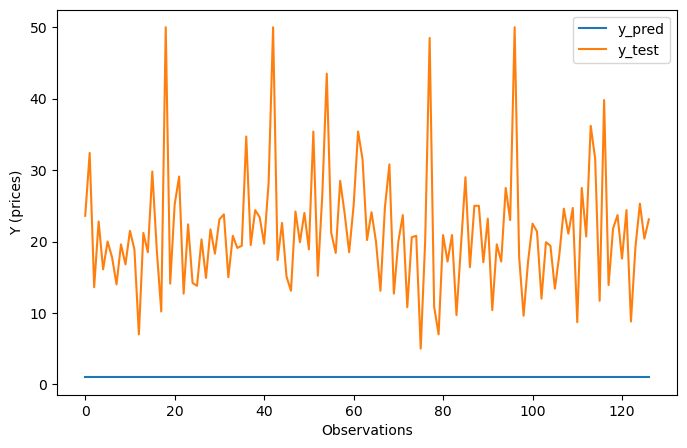

In [29]:
import matplotlib.pyplot as plt

def plot_two_ys(y_pred, y_test):
    plt.figure(figsize=(8,5))
    plt.plot(y_pred, label = 'y_pred')
    plt.plot(y_test, label = 'y_test')
    plt.legend()
    plt.xlabel('Observations')
    plt.ylabel('Y (prices)')
    plt.show()
    
plot_two_ys(y_pred, y_test)

In [31]:
def mse(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2))
mse(y_test, y_pred)

486.73346456692906

# Predict mean

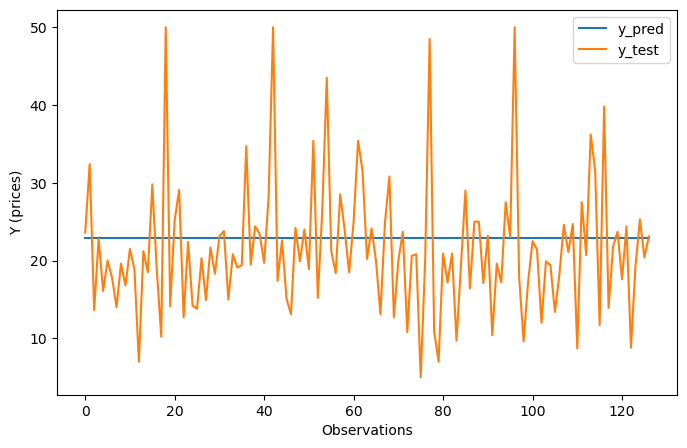

72.2607627995582


In [33]:
class DecisionTreeRegressor:
    
    def fit(self, X, y):
        self.mean_ = np.mean(y)
    
    def predict(self, X):
        return np.repeat(self.mean_, X.shape[0])

tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
y_pred

plot_two_ys(y_pred, y_test)
print(mse(y_test, y_pred))

# Now using the 9nth feature

In [39]:
X_train.shape

(379, 13)

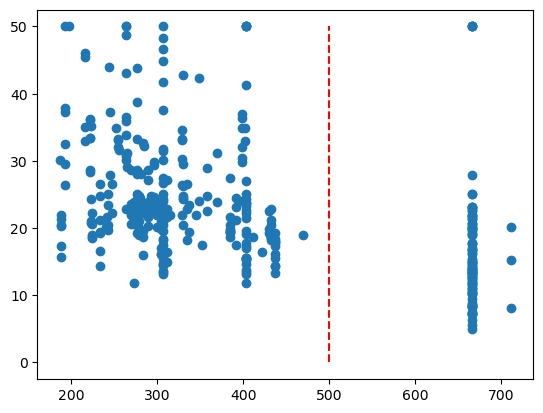

In [49]:
plt.scatter(X_train[:,9], y_train)
plt.plot([500, 500], [0, 50], c = 'r', linestyle = 'dashed')

Big values for X_train[:,9] usually corresponds to low values for y

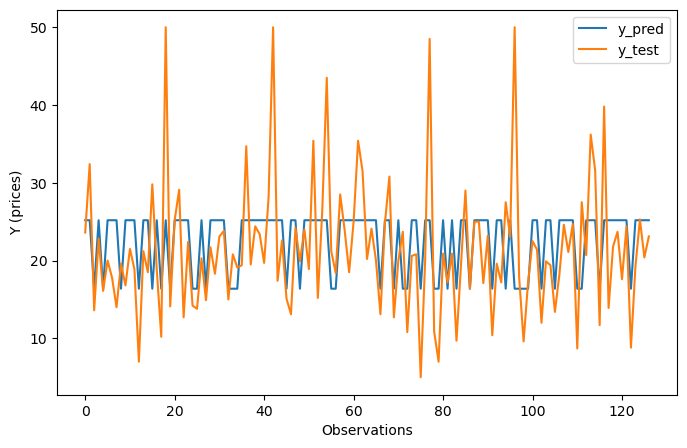

58.38832728769185


In [50]:
class DecisionTreeRegressor:
    
    def fit(self, X, y):
        condition = X[:, 9] > 500
        self.mean_1 = np.mean(y[condition])
        self.mean_2 = np.mean(y[~condition])
    
    def predict(self, X):
        n_rows = len(X)
        results = []
        for i in range(n_rows):
            if X[i, 9] >= 500:
                result = self.mean_1
            else:
                result = self.mean_2
            results.append(result)
        return results

tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
y_pred

plot_two_ys(y_pred, y_test)
print(mse(y_test, y_pred))

We want to drop the mse, let's look at all features of the data set and choose the best splitting condition based on the mse drop ie the best value and the feature

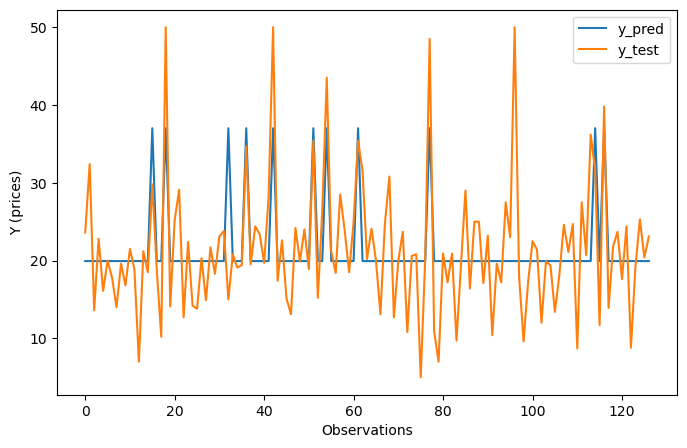

45.187168040437285


In [55]:
class DecisionTreeRegressor:
    
    def __init__(self):
        self.tree = {}
    
    def mse(self, y_true, y_pred):
        return np.mean(np.power(y_true - y_pred, 2))
    
    def fit(self, X, y, tree_path = '0'):
        
        minimum_mse = None
        self.best_feature_ = None
        self.best_value_ = None
        
        for feature in range(X.shape[1]):
            for value in X[:, feature]:
                
                # select observations which are less than the value
                less_than_obs = X[:, feature] <= value
                
                # split in the parts that are less than, and the one bigger than the value
                X1, y1 = X[less_than_obs], y[less_than_obs]
                X2, y2 = X[~less_than_obs], y[~less_than_obs]
                
                # compute weighted mse for that split
                MSE1 = self.mse(y1, np.mean(y1))
                MSE2 = self.mse(y2, np.mean(y2))
                weight_1 = len(y1) / len(y)
                weight_2 = len(y2) / len(y)
                weighted_mse = weight_1 * MSE1 + weight_2 * MSE2
                
                # update MSE
                if minimum_mse is None or weighted_mse < minimum_mse:
                    minimum_mse = weighted_mse
                    self.best_feature_ = feature
                    self.best_value_ = value
        
        final_cond = X[:, self.best_feature_] >= self.best_value_
        self.mean_1 = np.mean(y[final_cond])
        self.mean_2 = np.mean(y[~final_cond])
    
    def predict(self, X):
        n_rows = len(X)
        results = []
        for i in range(n_rows):
            if X[i, self.best_feature_] >= self.best_value_:
                result = self.mean_1
            else:
                result = self.mean_2
            results.append(result)
        return np.array(results)

tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
y_pred

plot_two_ys(y_pred, y_test)
print(mse(y_test, y_pred))

Now we use a tree to ask multiple splitting questions and choose the best one each time

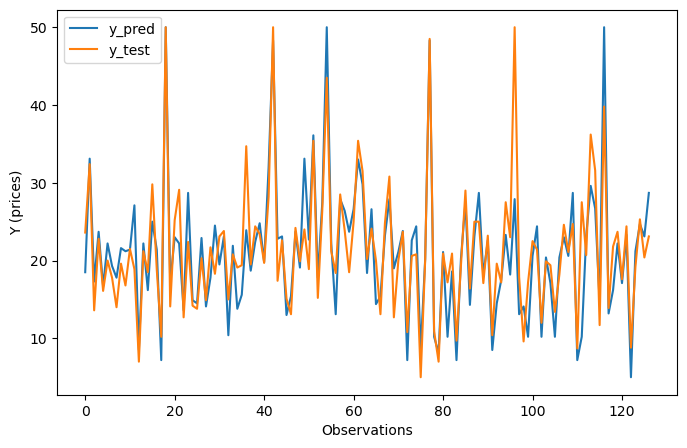

18.5928346456693


In [60]:
class DecisionTreeRegressor:
    
    def __init__(self, max_depth = None, min_samples_leaf = 1):
        self.tree_ = {}
        self.max_depth_ = max_depth
    
    def mse(self, y_true, y_pred):
        return np.mean(np.power(y_true - y_pred, 2))
    
    def fit(self, X, y, tree_path = '0'):
        
        if len(tree_path) - 1 == self.max_depth_ or X.shape[0] <= 1:
            self.tree_[tree_path] = np.mean(y)
            return
        
        minimum_mse = None
        best_split = None
        
        for feature in range(X.shape[1]):
            for value in sorted(set(X[:, feature])):
                
                # select observations which are less than the value
                less_than_obs = X[:, feature] <= value
                
                # split in the parts that are less than, and the one bigger than the value
                X1, y1 = X[less_than_obs], y[less_than_obs]
                X2, y2 = X[~less_than_obs], y[~less_than_obs]
                
                # compute weighted mse for that split
                MSE1 = self.mse(y1, np.mean(y1))
                MSE2 = self.mse(y2, np.mean(y2))
                weight_1 = len(y1) / len(y)
                weight_2 = len(y2) / len(y)
                weighted_mse = weight_1 * MSE1 + weight_2 * MSE2
                
                # update MSE
                if minimum_mse is None or weighted_mse < minimum_mse:
                    minimum_mse = weighted_mse
                    best_split = (feature, value)
        
        feature, value = best_split
        splitting_condition = X[:, feature] <= value
        X1, y1, X2, y2 = X[splitting_condition], y[splitting_condition], \
                            X[~splitting_condition], y[~splitting_condition]
        
        # add tuple to tree
        self.tree_[tree_path] = best_split
        
        # continue to grow the tree recursively
        self.fit(X1, y1, tree_path + '0')
        self.fit(X2, y2, tree_path + '1')
        
    def predict(self, X):
        results = []
        for i in range(X.shape[0]):
            tree_path = '0'
            while True:
                value_for_path = self.tree_[tree_path]
                if type(value_for_path) != tuple:
                    result = value_for_path
                    break
                feature, value = value_for_path
                if X[i, feature] <= value:
                    tree_path += '0'
                else:
                    tree_path += '1'
            results.append(result)
        return np.array(results) 
        
tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
y_pred

plot_two_ys(y_pred, y_test)
print(mse(y_test, y_pred))

## Gradient Boosting

In [65]:
class GradientBoostingReg:
    
    def fit(self, X, y):
        
        tree_num = 100
        max_depth = 3
        
        self.trees = []
        
        for i in range(tree_num):
            tree = DecisionTreeRegressor(max_depth = max_depth)
            tree.fit(X, y - self.predict(X))
            self.trees.append(tree)
            
    def predict(self, X):
        
        learning_rate = 0.1
        
        trees_predictions = np.zeros((len(X), len(self.trees)))
        
        for i, tree in enumerate(self.trees):
            
            # predict with a tree and multiply by learning rate
            trees_predictions[:, i] = tree.predict(X) * (1 if i == 0 else learning_rate)
        
        return np.sum(trees_predictions, axis = 1)
    
np.random.seed(42)
model = GradientBoostingReg()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse(y_test, y_pred)

8.815181609541877

In [67]:
np.random.seed(42)
sklearn_model = GradientBoostingRegressor()
sklearn_model.fit(X_train, y_train)
mse(y_test, sklearn_model.predict(X_test))

8.956140984840566

# Conclusion

In the end our algorithm gives even better results than the sklearn library! However it takes around 30 seconds to run instead of almost immediate response from sklearn, which is optimized for it.